In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from copy import deepcopy

import algorithms
import classifiers

In [3]:
def generate_data1(N, t, rv_params):
    """
    Generating a high-dimensional dataset with a change point.
    
    Parameters:
    - N: Total length of the dataset
    - t: Change point
    - rv_params: A list of dictionaries. Each dictionary contains parameters for two normal distributions 
                 (before and after the change point) for each r.v.
                 Example: [{'mu1': 0, 'sigma1': 1, 'mu2': 5, 'sigma2': 2}, ...]
    
    Returns:
    - data: A 2D numpy array where each row corresponds to an r.v. and each column corresponds to a data point.
    """
    
    data = []
    
    for params in rv_params:
        before_change = np.random.normal(params['mu1'], params['sigma1'], t)
        after_change = np.random.normal(params['mu2'], params['sigma2'], N - t)
        rv_data = np.concatenate([before_change, after_change])
        data.append(rv_data)
    
    return np.array(data)

# Example usage:
N = 1000
t = 700
rv_params = [
    {'mu1': 0, 'sigma1': 1, 'mu2': 5, 'sigma2': 2},
    {'mu1': 3, 'sigma1': 1, 'mu2': 2, 'sigma2': 2},
    {'mu1': -2, 'sigma1': 2, 'mu2': 0, 'sigma2': 1},
    {'mu1': 5, 'sigma1': 2, 'mu2': -3, 'sigma2': 1},
    {'mu1': 0, 'sigma1': 0.5, 'mu2': -2, 'sigma2': 1.5},
]

data = generate_data1(N, t, rv_params)
print(data)

[[ 0.59590941 -0.62621309  0.06379033 ...  7.16128256  2.25224567
   9.89999429]
 [ 2.02623629  4.20160457  4.13702005 ...  1.57029243  3.94038571
  -0.40701434]
 [-6.24814207 -0.02968045 -2.2177744  ... -1.27790859  0.3815312
   0.14176012]
 [ 7.38221334  5.86759664  4.93543513 ... -5.00548068 -2.28539233
  -3.28574911]
 [-0.01934558 -0.06806905 -0.02833432 ... -5.0886073  -5.27576258
  -1.39872166]]


In [4]:
import numpy as np

def generate_data2(N, t, dims, mu_start=0, mu_step=1, sigma1=1, mu_shift=5, sigma2=2):
    """
    Generate high-dimensional data with a change point.
    
    Parameters:
    - N: Total length of the dataset
    - t: Change point
    - dims: Number of dimensions (r.v.s)
    - mu_start: Starting mean for the first r.v. for the first distribution
    - mu_step: Increase in mean for each subsequent r.v. for the first distribution
    - sigma1: Standard deviation for the first distribution
    - mu_shift: Shift in mean for the second distribution relative to the first
    - sigma2: Standard deviation for the second distribution
    
    Returns:
    - data: A 2D numpy array where each row corresponds to an r.v. and each column corresponds to a data point.
    """
    
    data = []
    
    for i in range(dims):
        mu1 = mu_start + i * mu_step
        mu2 = mu1 + mu_shift
        
        before_change = np.random.normal(mu1, sigma1, t)
        after_change = np.random.normal(mu2, sigma2, N - t)
        
        rv_data = np.concatenate([before_change, after_change])
        data.append(rv_data)
    
    return np.array(data)

# Example usage:
N = 1000
t = 700
dims = 5

data = generate_data2(N, t, dims)
print(data)

[[-2.02647277  2.79098386 -0.0334138  ...  1.44537339  2.4875548
   3.39799697]
 [-0.10082137  3.15674216 -0.19225219 ...  7.90241215  6.62196523
   4.14700905]
 [ 3.63706755  1.64369184  0.94714931 ...  5.67940699  4.52707765
   7.22499582]
 [ 2.13044113  3.10782931  3.47558731 ...  8.72318675  8.41554249
   9.88021752]
 [ 3.51382459  2.30875628  4.39699434 ...  6.9100543  10.12933553
   6.7102709 ]]


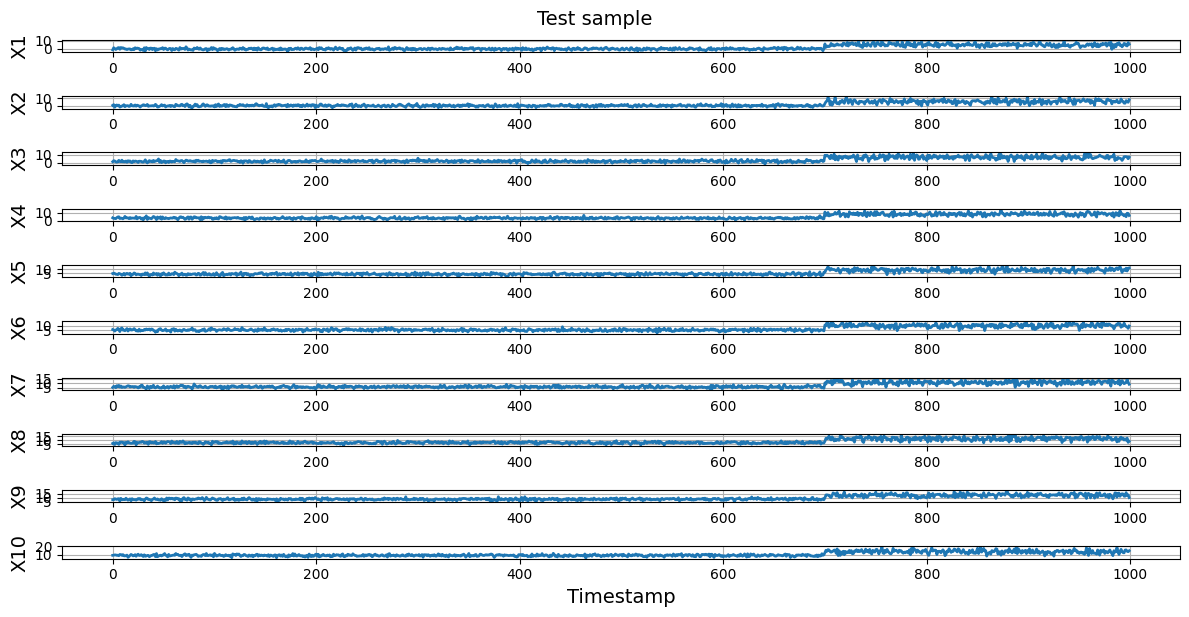

In [5]:
N = 1000
t = 700
dims = 10
X = generate_data2(N, t, dims)

T = np.arange(N)  # Note: The length of T should be N, not len(X)
plt.figure(figsize=(12, 6))

# Plot each dimension separately
for i in range(dims):
    plt.subplot(dims, 1, i+1)
    plt.plot(T, X[i], linewidth=2)
    plt.ylabel(f'X{i+1}', size=14)
    if i == dims - 1:
        plt.xlabel('Timestamp', size=14)
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Test sample', size=14, y=1.02)
plt.show()

In [19]:
def generate_synthetic_data_v2(N, change_points_info, rv_params):
    if change_points_info['count'] != len(change_points_info['indices']):
        raise ValueError("The count of change points does not match the number of indices provided.")
    data = np.zeros((len(rv_params), N))
    cps = [0] + change_points_info['indices'] + [N]
    for i in range(len(cps) - 1):
        start, end = cps[i], cps[i + 1]
        for rv_index, rv in enumerate(rv_params):
            segment_params = rv[i]
            if segment_params['dist'] == 'normal':
                data[rv_index, start:end] = np.random.normal(segment_params['mu'], segment_params['sigma'], end - start)
            elif segment_params['dist'] == 'uniform':
                data[rv_index, start:end] = np.random.uniform(segment_params['low'], segment_params['high'], end - start)
    return data

In [21]:
N = 1000
dims = 1
indices = [300,600]
cpcount = 2
change_points_info = {'indices': indices, 'count': cpcount}
rv_params = [
    [{'dist': 'normal', 'mu': 0, 'sigma': 1}, {'dist': 'uniform', 'low': 0, 'high': 5}, {'dist': 'normal', 'mu': 5, 'sigma': 2}],
    [{'dist': 'uniform', 'low': -5, 'high': 0}, {'dist': 'normal', 'mu': 2, 'sigma': 1}, {'dist': 'uniform', 'low': 5, 'high': 10}]
]

# Generate synthetic data
synthetic_data = generate_synthetic_data_v2(N, change_points_info, rv_params)

Data generated!


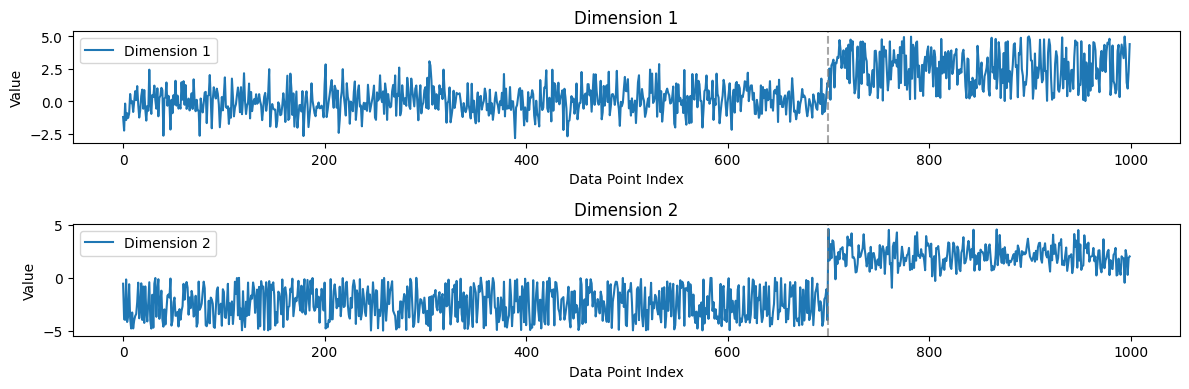

In [27]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  
from copy import deepcopy

# Assuming classifiers.py and algorithms.py are in the same directory
from classifiers import FitMyNN
from algorithms import ChangePointDetectionClassifier_RuLSIF

from sklearn.metrics import roc_curve, roc_auc_score

# Modified roc_auc
def change_point_roc_auc(T_label, label, T_score, score, window_size):
    new_label = np.zeros(len(label))
    T_change = T_label[label == 1]
    for t in T_change:
        cond = (T_label-t < 2 * window_size) & (T_label-t >= 0)
        new_label[cond] = 1
        
    new_label = new_label[T_score]
    
    # Check if new_label has both classes present
    if len(np.unique(new_label)) < 2:
        # Handle the single-class case appropriately
        print("Warning: Only one class present in y_true. ROC AUC score is not defined in that case.")
        return None  # Or return an indicative value like 0.5 or a message
    
    auc = roc_auc_score(new_label, score)
    return auc

# High-dimensional synthetic data generation function
def generate_synthetic_data_v2(N, change_points_info, rv_params):
    if change_points_info['count'] != len(change_points_info['indices']):
        raise ValueError("The count of change points does not match the number of indices provided.")
    data = np.zeros((len(rv_params), N))
    cps = [0] + change_points_info['indices'] + [N]
    for i in range(len(cps) - 1):
        start, end = cps[i], cps[i + 1]
        for rv_index, rv in enumerate(rv_params):
            segment_params = rv[i]
            if segment_params['dist'] == 'normal':
                data[rv_index, start:end] = np.random.normal(segment_params['mu'], segment_params['sigma'], end - start)
            elif segment_params['dist'] == 'uniform':
                data[rv_index, start:end] = np.random.uniform(segment_params['low'], segment_params['high'], end - start)
    return data

def plot_synthetic_data_separate(data, change_points_info):
    """
    Plot each dimension of the synthetic data on a separate subplot.
    
    Parameters:
    - data (np.ndarray): The synthetic dataset to plot, where each row is a random variable.
    - change_points_info (dict): Information about the change points to highlight them in the plot.
    """
    num_variables = data.shape[0]  # Number of dimensions/random variables
    fig, axes = plt.subplots(num_variables, 1, figsize=(12, 2 * num_variables))  # Create subplots for each dimension
    
    for i, ax in enumerate(axes):
        ax.plot(data[i, :], label=f'Dimension {i+1}')
        
        # Highlight change points
        for cp in change_points_info['indices']:
            ax.axvline(x=cp, linestyle='--', color='gray', alpha=0.7)
        
        ax.set_title(f'Dimension {i+1}')
        ax.set_xlabel('Data Point Index')
        ax.set_ylabel('Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Data generation parameters
N = 1000
dims = 1
indices = [700]
cpcount = 1
change_points_info = {'indices': indices, 'count': cpcount}
rv_params = [
    [{'dist': 'normal', 'mu': 0, 'sigma': 1}, {'dist': 'uniform', 'low': 0, 'high': 5}, {'dist': 'normal', 'mu': 5, 'sigma': 2}],
    [{'dist': 'uniform', 'low': -5, 'high': 0}, {'dist': 'normal', 'mu': 2, 'sigma': 1}, {'dist': 'uniform', 'low': 5, 'high': 10}]
]

# Generate synthetic data
synthetic_data = generate_synthetic_data_v2(N, change_points_info, rv_params)

print("Data generated!") # Testing

plot_synthetic_data_separate(synthetic_data, change_points_info) # Plot data

X_full = synthetic_data.T

# Split data into training and testing sets
n_train = int(0.7 * X_full.shape[0])
X_train, X_test = X_full[:n_train], X_full[n_train:]

# Create labels for training data
y_train = np.zeros(n_train)
for cp in change_points_info['indices']:
    if cp < n_train:
        y_train[cp:] = 1

# Train the classifier
classifier = FitMyNN(n_hidden=20, dropout=0.5, n_epochs=50)
classifier.fit(X_train, y_train)

In [29]:
cpd = ChangePointDetectionClassifier_RuLSIF(base_classifier=classifier, window_size=50, step=10, n_runs=1, debug=1)
T_scores, scores = cpd.predict(X_test)

In [31]:
#real data
X_full = X[0]
T_scores, scores = cpd.predict(X_full)